In [1]:
#Load the necessary Python packages
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import median_test
from scipy.stats import rankdata
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data from the house_data_2024.csv file and creating a DataFrame to store the imported data
data_original=pd.read_csv('house_data_2024.csv')
data_original

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront
0,1,221900,3,1.00,109.624675,524.897807,0
1,2,538000,3,2.25,238.758826,672.798216,0
2,3,180000,2,1.00,71.534745,929.022668,0
3,4,604000,4,3.00,182.088443,464.511334,0
4,5,510000,3,2.00,156.075808,750.650316,0
...,...,...,...,...,...,...,...
21596,21596,520000,2,2.25,142.140468,91.137124,0
21597,21597,679950,5,2.75,334.448160,876.718692,0
21598,21598,1575000,4,3.25,316.796730,940.635452,0
21599,21599,541800,4,2.50,289.669268,730.769231,0


# Task 1

## Question 1

### Initial Exploratory Analysis- Original Data

In [3]:
#Inspecting the data structure of the DataFrame
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21601 entries, 0 to 21600
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          21601 non-null  int64  
 1   price       21601 non-null  int64  
 2   bedrooms    21601 non-null  int64  
 3   bathrooms   21601 non-null  float64
 4   sqm_living  21601 non-null  float64
 5   sqm_lot     21601 non-null  float64
 6   waterfront  21601 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


There are 21601 observations and 7 variables in the data set (including 1 dependent variable - Price, and 5 independent variables (predictors)) (id is not a variable)

It also appears that the data set does not contain any null (missing values) as the number of non-null values in each column is the same as the number of observations (21601) included in the data set.

There are no categorical variables in the data set, as all variables are either of integer or floating type. (not very sure but integer could be categorical i.e waterfront or not, )

In [4]:
#Obtaining descriptive statistics of all numerical variables in the data set
data_original.describe().round(2)

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront
count,21601.00,21601.00,21601.00,21601.00,21601.00,21601.00,21601.00
mean,10800.46,544686.84,3.38,2.12,197.85,1408.65,0.01
std,6235.39,769898.28,1.14,1.01,684.42,3907.06,0.11
min,1.00,75000.00,0.00,0.00,26.94,48.31,0.00
25%,5401.00,321500.00,3.00,1.75,132.85,468.23,0.00
50%,10800.00,450000.00,3.00,2.25,177.44,707.92,0.00
75%,16200.00,645000.00,4.00,2.50,236.90,993.68,0.00
max,21600.00,99999999.00,99.00,99.00,99999.00,153414.99,9.00


Using the .describe() function, I can spot a potential abnormal observation in the data set with 99 bedrooms and 99 bathrooms. The property has a 99999.00 square meter of living space, and is priced at 99999999.00. This is an extreme value (outlier) as the price is 155 times higher than the Q3 (75 percent quartile) price at 645000

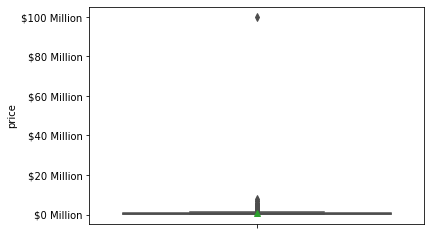

In [5]:
#Plotting a box plot to investigate outliers in the data set
ax = sns.boxplot(y='price', data=data_original, palette='bright', showmeans=True)

# Function to format the y-axis in millions
formatter = FuncFormatter(lambda y, _: f'${y / 1e6:.0f} Million')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.show()

The above box plot confirms that there is only 1 observation that can be considered as extreme outlier as the price is close to 100 million dollars, whereas all other observations are below the 20 million dollars mark. 

Therefore, I will need to remove this observation from the data set, otherwise, it will greatly affect the performance of my statistical modelling.

### Data Cleaning - Removing Outlier

In [6]:
#Identifying the index of the aforementioned outlier in the data set
data_original[data_original['price']==max(data_original['price'])]

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront
9999,9999,99999999,99,99.0,99999.0,99999.0,9


I managed to discover that the outlier has an index of 9999 in the data set. Now, I will create a copy of the original data set, remove the outlier and continue working on my analyses. 

I did this because it is not advised to remove any data from the actual data set. And to overcome this, I instead created a copy of the original data and performed data cleaning.

In [7]:
#Creating a copy of the original data set
data_copy=data_original.copy()

#Removing the outlier from the data_copy DataFrame
data_copy = data_copy.drop(index=9999)

After dropping the outlier using the .drop() function, I investigated whether there is any other observation that can potentially affect my statistical modelling. 

Hence, I re-plotted the box plot and run the .describe() function as follows:

### Exploratory Analysis- Working Data (data_copy DataFrame)

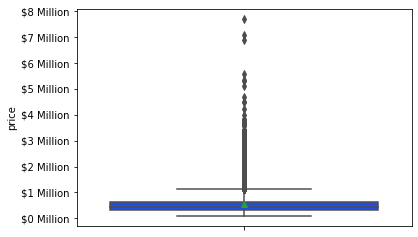

In [8]:
#Plotting a box plot to investigate distribution of house prices
ax = sns.boxplot(y='price', data=data_copy, palette='bright', showmeans=True)

# Function to format the y-axis in millions
formatter = FuncFormatter(lambda y, _: f'${y / 1e6:.0f} Million')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [9]:
#Obtaining descriptive statistics of all numerical variables in the data_copy DataFrame
data_copy.describe().round(2)

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront
count,21600.00,21600.00,21600.00,21600.00,21600.00,21600.00,21600.00
mean,10800.50,540082.43,3.37,2.11,193.23,1404.08,0.01
std,6235.53,367144.54,0.93,0.77,85.32,3849.13,0.09
min,1.00,75000.00,0.00,0.00,26.94,48.31,0.00
25%,5400.75,321500.00,3.00,1.75,132.78,468.23,0.00
50%,10800.50,450000.00,3.00,2.25,177.44,707.92,0.00
75%,16200.25,645000.00,4.00,2.50,236.90,993.61,0.00
max,21600.00,7700000.00,33.00,8.00,1257.90,153414.99,1.00


See that after remove outliner, waterfront is just a boolean now with 0 and 1. Also, please check if discrete var could be considered categorical or not...

In [10]:
#Descriptive statistics of the 'price' variable- data_copy DataFrame
stats.describe(data_copy['price'])

DescribeResult(nobs=21600, minmax=(75000, 7700000), mean=540082.4292592593, variance=134795109808.47058, skewness=4.024719119466403, kurtosis=34.59035294122284)

In [11]:
#Descriptive statistics of the 'price' variable- data_original DataFrame
stats.describe(data_original['price'])

DescribeResult(nobs=21601, minmax=(75000, 99999999), mean=544686.8418591731, variance=592743362338.8341, skewness=100.23458311537557, kurtosis=12891.663718272875)

The variance in data_original is approximately 4.40 times larger than the variance in data_copy. 

The removal of the outlier from data_original to create data_copy has had a substantial impact on the statistical properties of the dataset:

Reduced variance: Indicating a more consistent spread of data around the mean.
Decreased mean: Suggesting the outlier was a high value pulling the average upwards.
Lower skewness: Resulting in a more symmetric distribution.
Decreased kurtosis: Indicating fewer extreme values and a distribution closer to normal

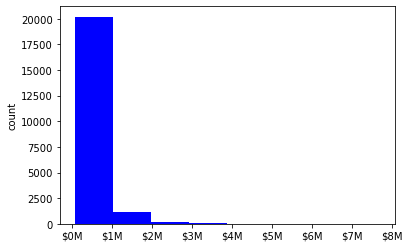

In [12]:
# Plotting the data distribution of the 'price' variable (data_copy)
ax = plt.hist(data_copy['price'] / 1e6, bins=8, color='blue')

# Function to format the x-axis in millions
formatter = FuncFormatter(lambda x, _: f'${x:.0f}M')

#Adding a title to the y-axis
plt.ylabel('count')          

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

Price is a strongly right, positively, skewed variable. House prices vary between 75000 and 7700000. Average house price is 540082. It might also be necessary to look at the median house price which is 450000. The standard deviation is 367145 (calculated by np.sqrt(134795109808.4706)). 50 percent of the houses are priced more than 450000 and 25 percent are priced more than 645000. There are some possible outliers in the long right tail of the distribution, above about 1.5 million dollars (according to the boxplot and distribution histogram)


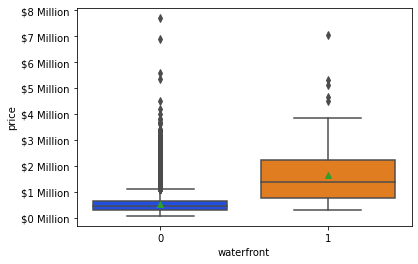

In [13]:
#Plotting a box plot to investigate the distribution of the houses in the two subgroups, with waterfront and without

ax = sns.boxplot(x='waterfront', y='price', data=data_copy, palette='bright', showmeans=True)

# Function to format the y-axis in millions
formatter = FuncFormatter(lambda y, _: f'${y / 1e6:.0f} Million')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [14]:
#Descriptive statistics of prices for houses without waterfront
data_copy.loc[data_copy['waterfront']==0, 'price'].describe().apply(lambda x: format(x, '.2f'))

count      21437.00
mean      531552.67
std       341602.10
min        75000.00
25%       320000.00
50%       450000.00
75%       639900.00
max      7700000.00
Name: price, dtype: object

In [15]:
#Descriptive statistics of prices for houses with waterfront
data_copy.loc[data_copy['waterfront']==1, 'price'].describe().apply(lambda x: format(x, '.2f'))

count        163.00
mean     1661876.02
std      1120371.73
min       285000.00
25%       760000.00
50%      1400000.00
75%      2215000.00
max      7062500.00
Name: price, dtype: object

In [16]:
#Descriptive statistics of prices for houses without waterfront
stats.describe(data_copy.loc[data_copy['waterfront']==0, 'price'])

DescribeResult(nobs=21437, minmax=(75000, 7700000), mean=531552.6743480897, variance=116691993510.25653, skewness=3.655964715365697, kurtosis=31.39380697105507)

In [17]:
#Descriptive statistics of prices for houses with waterfront
stats.describe(data_copy.loc[data_copy['waterfront']==1, 'price'])

DescribeResult(nobs=163, minmax=(285000, 7062500), mean=1661876.0245398772, variance=1255232816099.802, skewness=1.4427023109648562, kurtosis=3.127041653743727)

In [18]:
#Calculating the difference in average (mean) price of houses with and without waterfront
mean_dif= data_copy.loc[data_copy['waterfront'] == 1, 'price'].mean() - data_copy.loc[data_copy['waterfront'] == 0, 'price'].mean()

#Calculating the difference in median price of houses with and without waterfront
median_dif= data_copy.loc[data_copy['waterfront'] == 1, 'price'].median() - data_copy.loc[data_copy['waterfront'] == 0, 'price'].median()

print('Mean difference in price is: ', mean_dif)
print('Mean difference in price is: ', median_dif)

Mean difference in price is:  1130323.3501917874
Mean difference in price is:  950000.0


It was found that 99.25% (21437 out of 21600) of the houses included in the data set does not have waterfront. Furthermore, houses with no waterfront, on overage, cost less than houses with waterfront. The difference in average price is 1130323.35, and the difference in median price is 950000.


From the box plot, it also appears that houses there are significantly more outliers in price for houses without  waterfront compared to those with waterfront.

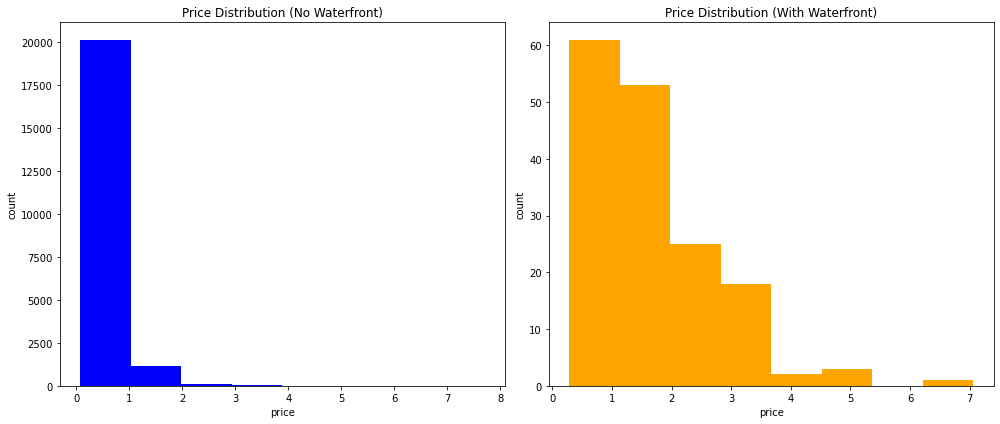

In [19]:
#Using ChatGPT for assistance
import matplotlib.pyplot as plt

# Filtering the data for each subgroup
no_waterfront = data_copy[data_copy['waterfront'] == 0]
with_waterfront = data_copy[data_copy['waterfront'] == 1]

# Plotting histograms
plt.figure(figsize=(14, 6))

# Histogram for 0 waterfront
plt.subplot(1, 2, 1)
plt.hist(no_waterfront['price'] / 1e6, bins=8, color='blue')
formatter = FuncFormatter(lambda x, _: f'${x:.0f}M')
plt.title('Price Distribution (No Waterfront)')
plt.xlabel('price')
plt.ylabel('count')

# Histogram for 1 waterfront
plt.subplot(1, 2, 2)
plt.hist(with_waterfront['price'] / 1e6, bins=8, color='orange')
formatter = FuncFormatter(lambda x, _: f'${x:.0f}M')
plt.title('Price Distribution (With Waterfront)')
plt.xlabel('price')
plt.ylabel('count')

plt.tight_layout()
plt.show()

> ⚠️ price is float so do line plot

From the above histograms, it is clear that both distributions are skewed to the right.

If found to be significant, the potential relationship and difference in house price is clear from the plots and summary statistics obtained in my previous exploratory analyses.

## Question 2 

### One-sided Student's t-test

The Student's t-test is a statistical method used to determine whether there is a significant difference between the means of two groups. In this context, the t-test is being conducted to compare the average values of two samples to investigate if the houses with waterfront are priced higher, on average, than houses with no waterfront.

In [20]:
stats.ttest_ind(data_copy.loc[data_copy['waterfront']==1, 'price'],data_copy.loc[data_copy['waterfront']==0, 'price'], equal_var = False)

Ttest_indResult(statistic=12.875998525086034, pvalue=1.3780183918988174e-26)

The hypotheses are:

$H_0:$ the two sample means are equal: $\mu_{\text{waterfront}}=\mu_{\text{no\_waterfront}}$

$H_1:$ the two sample means are not equal: $\mu_{\text{waterfront}} > \mu_{\text{no\_waterfront}}$

We choose $\alpha=0.05$ as standard.  

The test stat is  𝑡 = 12.88, which has a Student-t distribution with approximately 162 degrees of freedom (shown above), if the null hypothesis (that the means of the two groups are equal) and the assumptions of the test are true.


The chance that the resulting Student-t value would be more extreme than $12.88$, in the direction of the alternative hypothesis which is "higher or greater than", is very close to 0, i.e. here the p-val is $P(t_{162} > 12.88) = 1.38 \times 10^{-26}/2 = 6.9 \times 10^{-27}$ (since I am performing a one-sided t-test, the calculated p-value needs to be divided by two). This is $< 0.05$, so I reject the null and conclude that the 'waterfront' group mean amount spent is significantly greater than the 'no_waterfront' group mean. In other words, houses with 'waterfront' tend to have significantly higher prices, on average, than those with 'no_waterfront'. 

The test assumed that the data are iid in each group, the two groups are independent of each other and the 4th moment of the price in each group is finite. The 1st assumption relies on houses are priced independently of each other (i.e. the price of one house does not influence another). Additionally, prices in each group are drawn from the same distribution, ensuring consistent statistical properties. I assume these are true even though I can't really know for sure. 

The 2nd assumption relates to normality. This assumption holds because the size of each sample is large ('waterfront' sample contains 163 observations, and 'no_waterfront' sample contains 21437 observations). According to the Central Limit Theorem (CLT), with sufficiently large sample sizes, the sampling distribution of the mean tends to be normal regardless of the population distribution.

The final assumption will be satisfied if 'price' is a bounded variable. Clearly it is bounded below by \$0; further, since the number of houses is limited (as seen in the data set) and each housebuyer has finite amounts of money, I can regard price as implicitly bounded via these aspects. Thus, the 4th moment of 'price' will be finite and the 3rd assumption is satisfied. 

It should be noted that since the variances of the two samples (waterfront and no_waterfront) are not equal, the assumption of homoscedasticity does not hold. Therefore, the results of the Student's t-test may be misleading.

### Median test 

In [21]:
median_test(data_copy.loc[data_copy['waterfront']==1, 'price'],data_copy.loc[data_copy['waterfront']==0, 'price'])

(122.65671160672714,
 1.6578933299614663e-28,
 450000.0,
 array([[  152, 10591],
        [   11, 10846]], dtype=int64))

The hypotheses are:

$H_0:$ the two sample medians are equal: $\text{median}_{\text{waterfront}} = \text{median}_{\text{no_waterfront}}$

$H_1:$ the two sample medians are not equal: $\text{median}_{\text{waterfront}} \neq \text{median}_{\text{no_waterfront}}$


I choose $\alpha=0.05$ as standard and for consistency across tests.

In [22]:
#Constructing the contingency table to investigate the distribution of house prices relative to the median
#for the two samples 'waterfront' and 'no_waterfront'
med_price = data_copy['price'].median()
data_copy['price>med_price'] = np.where(data_copy['price'] > med_price,1,0)

contingency_table=pd.crosstab(data_copy['price>med_price'],data_copy['waterfront'], rownames=['price>median_price'], colnames=['Sample (waterfront)']);
contingency_table

Sample (waterfront),0,1
price>median_price,,
0,10846,11
1,10591,152


The test statistic is  122.66, which under the null follows a $\chi^2_1$ distribution where df=(number of rows−1)×(number of columns−1). 

In this case, the p-value is $P(\chi^2_1 > 122.66) = 1.66 \times 10^{-28}$. This is < 0.05, thus I can reject the null hypothesis. I can conclude that there is a significant difference in median between price for houses with waterfront and with no waterfront.

The assumptions made are:

Independence of the two groups: Similar to the previous discussion about the iid assumption of the Student's t-test, I have no idea about this, but I still must acknowledge what i assumed.

Each cell in the contingency table has expected value at least 5: This assumption holds in this case as all the expected values are above 5 according to the contigency table above

Data are i.i.d. in each group: Similar to the previous discussion about the iid assumption of the Student's t-test, I have no idea about this, but I still must acknowledge what I assumed.

Data are at least on the ordinal scale: price is a numerical variable, so this is satisfied.

### Mann-Whitney U test

In [23]:
data_copy['rank_price'] = rankdata(data_copy['price'])
data_copy

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront,price>med_price,rank_price
0,1,221900,3,1.00,109.624675,524.897807,0,0,1371.5
1,2,538000,3,2.25,238.758826,672.798216,0,1,13559.5
2,3,180000,2,1.00,71.534745,929.022668,0,0,487.0
3,4,604000,4,3.00,182.088443,464.511334,0,1,15382.0
4,5,510000,3,2.00,156.075808,750.650316,0,1,12738.5
...,...,...,...,...,...,...,...,...,...
21596,21596,520000,2,2.25,142.140468,91.137124,0,1,13003.0
21597,21597,679950,5,2.75,334.448160,876.718692,0,1,16872.0
21598,21598,1575000,4,3.25,316.796730,940.635452,0,1,21137.0
21599,21599,541800,4,2.50,289.669268,730.769231,0,1,13696.0


<AxesSubplot:xlabel='waterfront', ylabel='rank_price'>

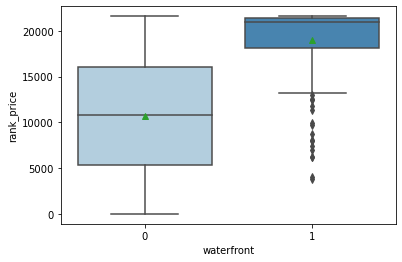

In [24]:
sns.boxplot(x=data_copy['waterfront'], y=data_copy['rank_price'], palette='Blues', showmeans=True)

In [25]:
#Calculating the sum of ranks for the two samples ('waterfront' and 'no_waterfront')
R1 = data_copy['rank_price'][data_copy['waterfront']==1]
R2 = data_copy['rank_price'][data_copy['waterfront']==0]
print([sum(R1), sum(R2)])

[3102327.0, 230188473.0]


In [26]:
from scipy.stats import mannwhitneyu
mannwhitneyu(data_copy.loc[data_copy['waterfront']==1, 'price'],data_copy.loc[data_copy['waterfront']==0, 'price'], alternative='greater')

MannwhitneyuResult(statistic=3088961.0, pvalue=1.6214734345185487e-64)

The hypotheses are:

$H_0:$ price in the 'waterfront' sample has the same distribution as price in the 'no_waterfront' sample:
$P(\text{price}_\text{waterfront} > \text{price}_\text{no_waterfront}) = 0.5$

$H_1:$ The price in the 'waterfront' sample is greater than the price in the 'no_waterfront' sample:
$P(\text{price}_\text{waterfront} > \text{price}_\text{no_waterfront}) > 0.5$

I choose  $\alpha=0.05$ as standard and for consistency across tests.

The test statistic assesses whether there is a difference in the sum of the ranks in each sample. Here it is 𝑈=3088961, which under the null follows a large sample normal distribution with mean and variance as given by the test. 

The sum of ranks for the waterfront group (R1) is 3102327, while the sum of ranks for 'no_waterfront' group (R2) is 230188473. The calculated U value from the Mann-Whitney U test is 𝑈 = 3088961. This can be used to calculate the Z statistic associated with 𝑈 = 3088961, using the formulas given in lecture: $Z = \frac{U - E(U)+0.5}{\sqrt{V(U)}} = \frac{3088961 - 1747115.5+ 0.5}{\sqrt{629014171167.83}}= 1.69 $

$U = SR_1 - 0.5n_1(n_1+1)= 3102327 -0.5*163*(163+1) = 3088961$

𝑉(𝑈)=𝑉(𝑆𝑅1)= (163*214378*(21600+1))/12 = 629014171167.83

𝐸(𝑈)=𝐸(𝑆𝑅1)-13366= 0.5*163*(21600+1)- 13366 = 1747115.5

𝐸(𝑈)=𝐸(𝑆𝑅2)-13366= 0.5*21437*(21600+1)- 13366 = 231516952.5

Note:  0.5𝑛1(𝑛1+1)= 0.5*163*(163+1)=13366


In [27]:
#Calculating the p_value for the given Z-statistic
from scipy.stats import norm
p_value= 1- norm.cdf(1.69)
p_value

0.045513977321549826

The one-sided p-value is then 𝑃(𝑍<1.69) which is 0.046 (as seen in the code cell above). This is < 0.05, thus I can reject the null hypothesis. 

I can conclude that there is a significant difference in the distribution of prices between the 'waterfront' and 'no_waterfront' samples, with the price in the 'waterfront' sample being significantly higher than in the 'no_waterfront' sample.

The assumptions made are:

Independence of the two samples: Again I have no idea, but I still must acknowledge what I assumed.

Data are i.i.d. in each group: Again I have no idea, but I still must acknowledge what I assumed.

Each group's sample size is large enough for the CLT to work: I only neded at least 8 in each group, so sample sizes of 'waterfront' (163 observations) and 'no_waterfront' (21437 observations) are more than sufficient.

Data are at least on the ordinal scale:  Since 'price' is a numerical variable, this assumption is satisfied.

## Question 3

The p-value of the t-test is $6.9 \times 10^{-27}$, while this number is $1.66 \times 10^{-28}$ for the median test, and 0.046 for the Mann-Whiteney U test.

If all the assumptions of the Student's t-test are satisfied, the test is known to have the most power. Although the t-test has the lowest p-value, which typically suggests the strongest evidence against the null hypothesis, one of the assumptions of the t-test is not satisfied as discussed in Question 2. This makes the t-test results less reliable and not trustworthy, despite the low p-value.

The Median test is valid since all its assumptions are satisfied, but it has a much lower power compared to the Mann-Whitney U test. It should be noted that the Median test achieved the lowest p-value among the three statistical tests.

The Mann-Whitney U test has more power than the Median test, and since the assumptions in the t-test are not satisfied, it has more power than both, despite its higher p-value compared to the other two statistical tests.

The Mann-Whitney U test is the most reliable in this case because it satisfies all its assumptions and has more power than the Median test, making its results trustworthy. While the t-test has a lower p-value, one of its assumptions is not met, rendering its results less reliable. Therefore, the Mann-Whitney U test's balance of valid assumptions and sufficient power makes it the most dependable choice for this analysis.

## Question 4

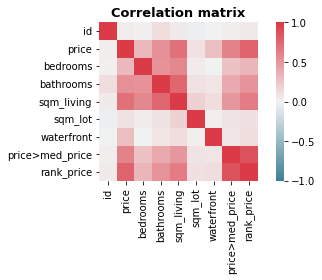

In [28]:
#Plotting Correlation Matrix to identify the correlations between variables
fig, ax = plt.subplots()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_copy.corr(), vmax=1, vmin=-1, center=0, square=True, ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()

In [29]:
#Displaying the strength of the correlations between variables
data_copy.corr().round(2)

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront,price>med_price,rank_price
id,1.00,0.03,0.01,0.11,0.04,-0.03,-0.01,0.03,0.04
price,0.03,1.00,0.31,0.53,0.70,0.09,0.27,0.61,0.78
bedrooms,0.01,0.31,1.00,0.52,0.58,0.03,-0.01,0.26,0.33
bathrooms,0.11,0.53,0.52,1.00,0.75,0.09,0.06,0.40,0.51
sqm_living,0.04,0.70,0.58,0.75,1.00,0.17,0.10,0.50,0.64
sqm_lot,-0.03,0.09,0.03,0.09,0.17,1.00,0.02,0.08,0.10
waterfront,-0.01,0.27,-0.01,0.06,0.10,0.02,1.00,0.08,0.12
price>med_price,0.03,0.61,0.26,0.40,0.50,0.08,0.08,1.00,0.87
rank_price,0.04,0.78,0.33,0.51,0.64,0.10,0.12,0.87,1.00


The correlation matrix shows a moderate to strong positive correlation between 'price' and 'sqm_living', indicating a potential linear relationship where larger living areas are associated with higher prices. 

A correlation coefficient of 0.70 between 'price' and 'sqm_living' indicates that 70% of the variation in house prices can be linearly explained by changes in the living area, assuming other factors remain constant.

Text(0, 0.5, 'price')

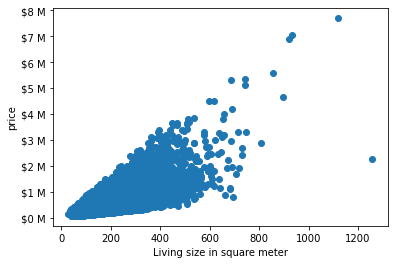

In [30]:
#Plotting a scatterplot to identify the relationship between 'price' and 'sqm_living'
plt.scatter(data_copy['sqm_living'],data_copy['price'])

# Function to format the y-axis in millions
formatter = FuncFormatter(lambda y, _: f'${y / 1e6:.0f} M')

# Apply the formatter to the y-axis
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Living size in square meter')
plt.ylabel('price')

The scatterplot shows a positive linear relationship between 'price' and 'sqm_living', with prices generally increasing as living area size increases. However, the relationship appears to be more complex at higher values of sqm_living, where price variability increases significantly. This suggests that while larger living areas tend to correspond with higher prices, other factors may contribute to price variability in larger homes. The increasing variance of 'price' at higher 'sqm_living' values could even indicate potential non-linearity.

Text(336.9714285714286, 0.5, 'price')

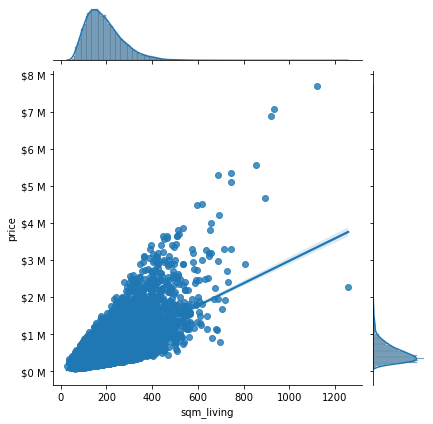

In [31]:
#Plotting a scatterplot to identify the relationship between 'price' and 'sqm_living'- with regression trend line fitted
sns.jointplot(x=data_copy['sqm_living'], y=data_copy['price'], kind="reg")

# Apply the formatter to the y-axis
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Living size in square meter')
plt.ylabel('price')

#plt.show()

With the inclusion of a trend line, the jointplot confirms a clear, positive linear relationship between 'price' and 'sqm_living'. Setting the kind parameter to 'reg' fits a best-fit regression trend line based on the data provided.

The shaded areas on the top and the right line shows the distribution of 'sqm_living' and 'price' respectively. As seen in the jointplot and the distribution plot of 'price' variable shown in Question 1, 'price' has a highly skewed distribution, particularly right skewed. 

To solve this, I can apply the logarithmic scale on 'price' so that the variability in this variable can be reduced.

In [32]:
#Creating a new column named 'log_price' to store the logarithmic transformation of prices
data_copy['log_price'] = np.log(data_copy['price'])
data_copy

,id,price,bedrooms,bathrooms,sqm_living,sqm_lot,waterfront,price>med_price,rank_price,log_price
0,1,221900,3,1.00,109.624675,524.897807,0,0,1371.5,12.309982
1,2,538000,3,2.25,238.758826,672.798216,0,1,13559.5,13.195614
2,3,180000,2,1.00,71.534745,929.022668,0,0,487.0,12.100712
3,4,604000,4,3.00,182.088443,464.511334,0,1,15382.0,13.311329
4,5,510000,3,2.00,156.075808,750.650316,0,1,12738.5,13.142166
...,...,...,...,...,...,...,...,...,...,...
21596,21596,520000,2,2.25,142.140468,91.137124,0,1,13003.0,13.161584
21597,21597,679950,5,2.75,334.448160,876.718692,0,1,16872.0,13.429775
21598,21598,1575000,4,3.25,316.796730,940.635452,0,1,21137.0,14.269766
21599,21599,541800,4,2.50,289.669268,730.769231,0,1,13696.0,13.202652


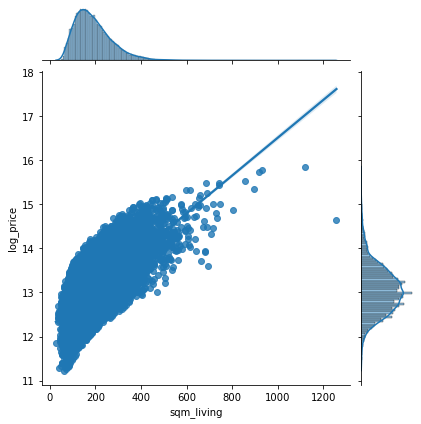

In [33]:
#Plotting a scatterplot to identify the relationship between 'log_price' and 'sqm_living'
#- with regression trend line fitted
sns.jointplot(x=data_copy['sqm_living'], y=data_copy['log_price'], kind="reg")

plt.xlabel('Living size in square meter')
plt.ylabel('Log of Price')
plt.show()

By transforming 'price' to 'log_price', the distribution of prices has become more normalized, reducing the right skewness observed in the original 'price' distribution. This transformation helps to stabilize the variance, making the distribution more symmetric and easier to model using linear regression.

Furthermore, the relationship between 'log_price' and 'sqm_living' appears more linear and consistent across different living area sizes. The transformation of 'price' has reduced the variability seen in the scatterplot and jointplot, particularly at higher values of 'sqm_living'. This results in a tighter clustering of data points around the regression line, indicating a stronger linear relationship between 'log_price' and 'sqm_living' compared to the original 'price' variable.

## Question 5

In [34]:
#Creating a copy of the 'data_copy' DataFrame consisting of only 2 variables used for OLS and LAD
reg_data = data_copy[['price', 'sqm_living']].dropna()
reg_data

,price,sqm_living
0,221900,109.624675
1,538000,238.758826
2,180000,71.534745
3,604000,182.088443
4,510000,156.075808
...,...,...
21596,520000,142.140468
21597,679950,334.448160
21598,1575000,316.796730
21599,541800,289.669268


In [35]:
#Fitting the OLS model
reg = smf.ols(formula='price ~ sqm_living', data=reg_data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.098e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:55:05   Log-Likelihood:            -3.0009e+05
No. Observations:               21600   AIC:                         6.002e+05
Df Residuals:                   21598   BIC:                         6.002e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.355e+04   4405.201     -9.887      0.000   -5.22e+04   -3.49e+04
sqm_living  3020.3863     20.855    144.828      0.000    2979.509    3061.264
==============================================================================
Omnibus:                    14824.811   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           546032.506
Skew:                           2.824   Prob(JB):                         0.00
Kurtosis:                      26.975   Cond. No.                         523.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As part of a comprehensive regression analysis, I am going to perform hypothesis testing to test the assumptions.

In question 5, the objective is to assess the relationship between house prices and living area size, which doesn’t have an inherent directional hypothesis (e.g., "larger living area should increase house price"). Therefore, a two-sided hypothesis testing is appropriate here.

In [36]:
#Performing t-test on the OLS model
hypothesis_reg = 'sqm_living = 0'
t_test_reg = reg.t_test(hypothesis_reg)  # 2-sided t-test  H0: beta_1 = 0
print(t_test_reg)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          3020.3863     20.855    144.828      0.000    2979.509    3061.264


As explained previously, since no direction is given in the question, the null hypothesis is

$H_0: \beta_1 = 0$ 
$H_1: \beta_1 \neq 0$,


I set $\alpha = 0.05$ as standard. The $t-stat = \frac{\hat{\beta_1}}{SE (\hat{\beta_1})} = \frac{3020.3863}{20.855} = 144.828$, with 21600 - 2 = 21598 degrees of freedom. The two-sided p-value is $2 \times P(t_{21598} > 144.828) = 0.000$. Since p-val < 0.05 I reject the null and conclude that there is a significant relationship between prices and the size of living area.

This test assumed all 5 LSA, including a constant error variance.

Next I refit the model using heteroskedasticity-robust SEs. Parameter estimates are exactly the same (as expected), but SEs, t-tstas, and Confidnece Intervals have all changed. SEs are larger than before (SE for sqm_living in the heteroskedasticity-robust OLS is 60.825, compared to 20.855 in the original OLS model). 

The following test assumed only LSA 1-4, allowing a non-constant error variance.

In [37]:
reg2 = smf.ols(formula='price ~ sqm_living', data=data_copy).fit(cov_type='HC0')
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     2466.
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:55:05   Log-Likelihood:            -3.0009e+05
No. Observations:               21600   AIC:                         6.002e+05
Df Residuals:                   21598   BIC:                         6.002e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.355e+04   1.08e+04     -4.031      0.000   -6.47e+04   -2.24e+04
sqm_living  3020.3863     60.825     49.657      0.000    2901.172    3139.601
==============================================================================
Omnibus:                    14824.811   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           546032.506
Skew:                           2.824   Prob(JB):                         0.00
Kurtosis:                      26.975   Cond. No.                         523.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [38]:
hypothesis_reg2 = 'sqm_living = 0'
t_test_reg2 = reg2.t_test(hypothesis_reg2)  # 2-sided t-test  H0: beta_1 = 0
print(t_test_reg2)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0          3020.3863     60.825     49.657      0.000    2901.172    3139.601


The hypotheses are the same as before:

$H_0: \beta_1 = 0$ 
$H_1: \beta_1 \neq 0$,
 
I set $\alpha = 0.05$ as standard. The $z-stat = \frac{\hat{\beta_1}}{SE (\hat{\beta_1})} = \frac{3020.3863}{60.825} = 49.657$, with 21600 - 2 = 21598 degrees of freedom. The two-sided p-value is $2 \times P(z_{21598} > 49.657) = 0.000$. Since p-val < 0.05 I reject the null and conclude that there is a significant relationship between prices and the size of living area.

This test assumed the first 4 LSA only.



Since both tests assumed that LSA 4 was satisfied, the large number of outliers in the sample (as seen in previous visualisations i.e box plots and histograms of the 'price' variable or scatterplot displaying the relationship between 'price' and 'sqm_living') make me question the validity of both OLS tests. This highlights the need to construct the LAD estimator, which is more resilient to the effects of outliers in the sample data.

In [39]:
# now fit model via LAD
mod = smf.quantreg('price ~ sqm_living', data=reg_data)
res = mod.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                  price   Pseudo R-squared:               0.2480
Model:                       QuantReg   Bandwidth:                   3.152e+04
Method:                 Least Squares   Sparsity:                    4.836e+05
Date:                Fri, 06 Sep 2024   No. Observations:                21600
Time:                        00:55:06   Df Residuals:                    21598
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.283e+04   4072.816     12.972      0.000    4.49e+04    6.08e+04
sqm_living  2332.2000     19.281    120.956      0.000    2294.407    2369.993
==============================================================================
"""